# Proyecto: Regresión con Redes Neuronales y Validación Cruzada para predecir el valor biene raíces de acuerdo a 13 características (features) dadas

## Usaremos la función `KFold` para realizar la Validación Cruzada.

## Veremos que para problemas de regresión la arquitectura de la red tiene una sola neurona de salida sin función de activación.

## En este caso la función de costo a minimizar es: `loss = 'mse'` (mean square error) 

## y para evaluar el resultado del entrenamiento usamos la métrica: `metrics='mae'` (mean absolute error)

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

# importamos dataset:
from keras.datasets import boston_housing

# importamos funciones para construir redes neuronales:
from tensorflow.keras import layers, models, optimizers, regularizers

# función para separar los datos en Cross-Validation:
from sklearn.model_selection import KFold

In [2]:
# Cargamos datos:
(features_train, labels_train), (features_test, labels_test) = boston_housing.load_data()

# Cada "feature" corresponde a 13 variables que determinan el precio "label" (en miles de dólares) de una casa.

## Exploramos datos:

In [3]:
# Exploramos datos:

print('El dataset "features_train" es de tamaño:' , features_train.shape)
print('El dataset "features_test" es de tamaño:' , features_test.shape)
print('Cada elemento de "features" es de tipo:' , type(features_train[0]))

print('\nEl dataset "labels_train" es de tamaño:' , labels_train.shape)
print('El dataset "labels_test" es de tamaño:' , labels_test.shape)
print('Cada elemento de "labels" es de tipo:' , type(labels_train[0]))

El dataset "features_train" es de tamaño: (404, 13)
El dataset "features_test" es de tamaño: (102, 13)
Cada elemento de "features" es de tipo: <class 'numpy.ndarray'>

El dataset "labels_train" es de tamaño: (404,)
El dataset "labels_test" es de tamaño: (102,)
Cada elemento de "labels" es de tipo: <class 'numpy.float64'>


## Estandarizamos los features columna por columna (ie. estandarizamos cada variable):

In [4]:
# Obtenemos la media de los features de entrenamiento, columna por columna:
mean_train = features_train.mean(axis=0)

# Obtenemos la desviación estándar de los features de entrenamiento, columna por columna:
std_train = features_train.std(axis=0)

# Estandarizamos features de entrenamiento (columna por columna):
x_train = (features_train - mean_train)/std_train

# Estandarizamos features de prueba (columna por columna):
# OBS: utilizamos la 'media' y 'sigma' de los datos de entrenamiento, 
# pues se supone que sólo se tiene conocimiento de los datos de entrenamiento.
x_test = (features_test - mean_train)/std_train

In [5]:
# Verificamos que cada variable esté estandarizada,
# es decir que la media y sigma de cada variable sean 0 y 1, respectivamente:

print('media en cada variable:', np.round( x_train.mean(axis=0) ) )
print('sigma en cada variable:', np.round( x_train.std(axis=0) ) )

media en cada variable: [-0.  0.  0. -0. -0.  0.  0.  0.  0. -0.  0.  0.  0.]
sigma en cada variable: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [6]:
# dimensión de los features para entrenar la red:
dim_feature = x_train[0].shape
dim_feature

(13,)

## Construimos la red neuronal dentro de una función:

In [7]:
# Construimos la red dentro de una función:

# Parametros de entrada: 'dimension del feature' y 'learning rate'
def build_model( dim_feature , lr ):

    # Construimos arquitectura de la red:
    model = models.Sequential()
    # Capa 1 (entrada)
    model.add( layers.Dense(64, activation='relu', input_shape=dim_feature ))
    # Capa 2
    model.add( layers.Dense(64, activation='relu' ))
    # Capa de salida (una sóla neurona sin función de activación para problemas de regresión)
    model.add( layers.Dense(1) )

    # visualzamos la arquitecura de la red:
    # model.summary()

    # optimizador:
    optim_meth = optimizers.Nadam(learning_rate=lr)

    # compilamos la red:
    model.compile(
        optimizer= optim_meth,
        loss='mse',  # <-- Función de costo a minimizar: mean square error (para problemas de regresión)
        metrics='mae'# <-- Métrica para evaluar entrenamiento: mean absolute error
        )

    return model

In [8]:
# ================= Parámetros que controlan la convergencia de la red =====================

# learning rate:
lr = 0.001

n_epochs = 20

n_batch_size = 16

# ===========================================================================================

## Construimos parámetros para hacer Cross Validation:

In [9]:
# Definimos el separador K-Fold para hacer Cross-Validation:

k = 5 # numero de particiones para K-fold

kf = KFold(n_splits= k )#, shuffle=True, random_state=2)

# k subconjuntos del mismo tamaño:

#  Fold 1: |+++++|*****|*****|*****|...|*****|
#  Fold 2: |*****|+++++|*****|*****|...|*****|
#  Fold 3: |*****|*****|+++++|*****|...|*****|
#  Fold 4: |*****|*****|*****|+++++|...|*****|
#  
#  Fold k: |*****|*****|*****|*****|...|+++++|

# |*****| <-- datos de entrenamiento
# |+++++| <-- datos de validación

In [10]:
# Inicia prueba de validación cruzada:

# Creamos listas vacía para guardar las curvas de 'loss' y 'accuracy' 
# con los datos de entrenamiento y validación en cada fold
all_loss_train_curve = []
all_accu_train_curve = []

all_loss_valid_curve = []
all_accu_valid_curve = []

j=1
# Tomamos los ínidices del dataset: 'x_train' mediante 'kf.split(x_train)'
# aunque también se pueden tomas de 'labels_train' mediante 'kf.split(labels_train)'
for id_train, id_val in kf.split(x_train): 
    print( '\n **************** Fold:' , j , '****************' )    

    # Seleccionamos Features y labels de entrenamiento en el Fold actual:
    print('Indices_train:\n',id_train)
    x_train_part = x_train[id_train]
    y_train_part = labels_train[id_train]

    # Seleccionamos Features y labels de validación en el Fold actual:
    print('\nIndices_validation:\n' , id_val)
    x_val = x_train[id_val]
    y_val = labels_train[id_val]

    # Creamos el modelo de red neuronal en el Fold actual:
    model = build_model(dim_feature , lr)

    # Entrenamos la red para el Fold actual:   
    print('\n <<<<< Entrenando red en el Fold actual >>>>>')
    training = model.fit(
        x_train_part,
        y_train_part,
        epochs=n_epochs,
        batch_size =n_batch_size,
        validation_data = (x_val, y_val),
        verbose=0
    )

    # Recordemos que podemos accesar a los resultados del entrenamiento a través de 'history'
    # por ejemplo en este caso 'training.history' es un diccionario de la forma:
    # {'loss':[valores de la curva loss con datos de entrenamiento], 
    #   'mae':[valores de la curva accuracy mae con datos de entrenamiento],
    #   'val_loss':[valores de la curva loss con datos de validación],
    #   'val_mae':[valores de la curva accuracy mae con datos de validación]
    # }

    # Extraemos las curvas de 'loss' y 'accuracy' para los datos de entrenamiento y validacion: 
    loss_train_curve = training.history['loss']
    accu_train_curve = training.history['mae']    

    loss_valid_curve = training.history['val_loss']
    accu_valid_curve = training.history['val_mae']

    # Vamos guardando las curvas en una lista:
    all_loss_train_curve.append( loss_train_curve )
    all_accu_train_curve.append( accu_train_curve )

    all_loss_valid_curve.append( loss_valid_curve )
    all_accu_valid_curve.append( accu_valid_curve )    
    
    j = j+1




 **************** Fold: 1 ****************
Indices_train:
 [ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296
 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312

## A continuación promediamos las curvas 'loss' y 'accuracy' para los datos de entrenamiento y validación:

In [11]:
mean_loss_train_curve = pd.DataFrame( all_loss_train_curve ).mean(axis=0)
mean_accu_train_curve = pd.DataFrame( all_accu_train_curve ).mean(axis=0)
mean_loss_valid_curve = pd.DataFrame( all_loss_valid_curve ).mean(axis=0)
mean_accu_valid_curve = pd.DataFrame( all_accu_valid_curve ).mean(axis=0)

<Figure size 432x288 with 0 Axes>

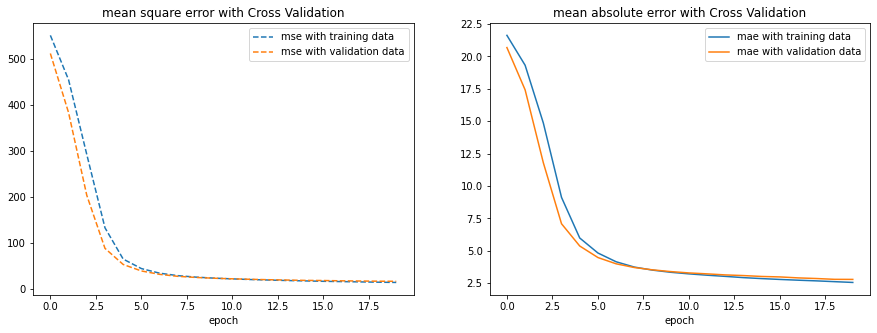

In [12]:
# Graficamos curvas:

# Eje x:
epoch = range( n_epochs )


plt.figure()
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(epoch, mean_loss_train_curve, '--', label='mse with training data')
plt.plot(epoch, mean_loss_valid_curve, '--', label='mse with validation data')
plt.legend()
plt.title('mean square error with Cross Validation')
plt.xlabel('epoch')


plt.subplot(1,2,2)
plt.plot(epoch, mean_accu_train_curve, label='mae with training data')
plt.plot(epoch, mean_accu_valid_curve, label='mae with validation data')
plt.legend()
plt.title('mean absolute error with Cross Validation')
plt.xlabel('epoch')
plt.show()

## Evaluamnos el modelo con los datos de prueba:

In [13]:
model.evaluate(x_test, labels_test)

4/4 [==============================] - 0s 2ms/step - loss: 22.7887 - mae: 3.4484


[22.788677215576172, 3.4484307765960693]

## Hacemos predicciones con el modelo entrenado:

In [14]:
# Predecimos las etiquetas de todos los features de prueba: 
y_predict = model.predict(x_test)

y_predict.shape

(102, 1)

In [15]:
# Predecimos una etiqueta en particular:

i = 10 #<--- indice del valor a predecir (< 102)

label_obs  = labels_test[i] #np.argmax(y_test[i])
label_aprx = y_predict[i]

print('    Etiqueta real: ', label_obs )
print('Etiqueta predicha: ', label_aprx )

    Etiqueta real:  18.6
Etiqueta predicha:  [14.406808]


In [16]:
# Diferencia promedio entre datos de prueba (observados y aproximados)
y_obs = labels_test.reshape( y_predict.shape )
err = ( np.linalg.norm( y_predict - y_obs) ) / (len(y_obs))
err

0.4726715752632877